In [7]:
from hcve_lib.utils import notebook_init

notebook_init()

from mlflow import set_tracking_uri

%autoreload 2
from deps.common import get_variables_cached
from hcve_lib.tracking import get_children_runs, load_pickled_artifact
from hcve_lib.tracking import get_completed_runs
from hcve_lib.tracking import is_root_run
from hcve_lib.visualisation import b
from utils import compute_standard_metrics
from hcve_lib.tracking import load_pickled_artifact
from hcve_lib.visualisation import h2
from toolz.curried import valmap
from pandas import DataFrame, Series
import plotly.figure_factory as ff
from hcve_lib.functional import statements
set_tracking_uri('http://localhost:5000')

data, metadata, X, y = get_variables_cached()

In [4]:
from hcve_lib.tracking import get_latest_root_completed_run


In [37]:
def get_lm_matrix(method_name: str, experiment_name: str='lm', include_mean: bool =False) -> DataFrame:
    run, result = get_latest_root_completed_run(experiment_name, method_name)
    metrics_lm = compute_standard_metrics(X, y, result)
    keys_first = set(pair[0] for pair in metrics_lm.keys())
    keys_second = set(pair[1] for pair in metrics_lm.keys())
    all_keys = keys_first.union(keys_second)
    matrix_lm = {
        key1: {
            key2: statements(
                metrics := metrics_lm.get((key1, key2)),
                metrics['c_index'] if metrics else None
            )
            for key2 in all_keys
        }
        for key1 in all_keys
    }

    matrix = DataFrame(matrix_lm)

    if include_mean:
        matrix['LM Mean'] = matrix.mean(axis=1)

    return matrix

def get_lco_column(method_name: str, experiment_name: str = 'optimized_lco' ) -> Series:
    runs_lco = get_completed_runs(experiment_name)
    last_run_lco = runs_lco[
        (runs_lco['tags.mlflow.parentRunId'].isna())
        & (runs_lco['tags.mlflow.runName'] == method_name)
    ].iloc[0]
    result_lco = load_pickled_artifact(last_run_lco['run_id'], 'result')
    metrics_lco = compute_standard_metrics(X, y, result_lco)
    metrics_lco_c_index = valmap(lambda _metrics: _metrics['c_index'], metrics_lco)
    return Series(metrics_lco_c_index)

def get_lm_lco_comparison(method_name: str, experiment_lm: str = 'lm', experiment_lco: str = 'lco' ) -> DataFrame:
    matrix = get_lm_matrix(method_name, experiment_lm)
    lco_column = get_lco_column(method_name, experiment_lco)
    matrix['Federated'] = lco_column
    return matrix

def plot_matrix(matrix: DataFrame) -> None:
    fig = ff.create_annotated_heatmap(
        matrix.round(2).to_numpy(),
        x=list(matrix.columns),
        y=list(matrix.index),
    )

    fig.update_layout(xaxis_title="Trained on", yaxis_title='Tested on')
    fig.show()

def plot_lm_lco_comparison(method_name: str, experiment_lm: str = 'lm', experiment_lco: str = 'lco'):
    h2(method_name)
    b(f" ({experiment_lm}, {experiment_lco})")
    plot_matrix(get_lm_lco_comparison(method_name, experiment_lm, experiment_lco))

In [13]:
lm_coxnet = get_lm_matrix('coxnet')
lm_gb = get_lm_matrix('gb')


In [40]:
plot_lm_lco_comparison('coxnet', 'lm', 'lco')

In [39]:
plot_lm_lco_comparison('gb', 'lm', 'lco')

In [38]:
plot_lm_lco_comparison('coxnet', 'optimized_lm', 'optimized_lco')

In [41]:
plot_lm_lco_comparison('gb', 'optimized_lm', 'optimized_lco')

OSError: No such file or directory: './mlruns/9/dcd4db41ea934f37a0626ed19762bf7d/artifacts/result'

In [23]:
lm_gb_optimized = get_lm_matrix('gb', 'optimized_lm')
lm_coxnet_optimized = get_lm_matrix('coxnet', 'optimized_lm')


In [24]:
plot_matrix(lm_gb_optimized-lm_gb)


In [111]:


data, metadata, X, y = get_variables_cached()
data_subset = data.loc[data.index]


def get_matrix(method_name):
    runs_lm = get_completed_runs('optimized_lm')
    last_run_lm = runs_lm[(runs_lm['tags.mlflow.parentRunId'].isna()) & (runs_lm['tags.method_name'] == method_name)].iloc[0]
    result_lm = load_pickled_artifact(last_run_lm['run_id'], 'result')
    metrics_lm = compute_standard_metrics(X, y, result_lm)

    keys_first = set(pair[0] for pair in metrics_lm.keys())
    keys_second = set(pair[1] for pair in metrics_lm.keys())
    all_keys = keys_first.union(keys_second)

    matrix_lm = {
        key1: {
            key2: statements(
                metrics := metrics_lm.get((key1, key2)),
                metrics['c_index'] if metrics else None
            )
            for key2 in all_keys
        }
        for key1 in all_keys
    }
    matrix = DataFrame(matrix_lm)
    matrix['LM Mean'] = matrix.mean(axis=1)

    runs_lco = get_completed_runs('optimized_lco')
    last_run_lco = runs_lco[(runs_lco['tags.mlflow.parentRunId'].isna()) & (runs_lco['tags.mlflow.runName'] == method_name)].iloc[0]
    try:
        result_lco = load_pickled_artifact(last_run_lco['run_id'], 'result')
        metrics_lco = compute_standard_metrics(X, y, result_lco)
        metrics_lco_c_index = valmap(lambda _metrics: _metrics['c_index'], metrics_lco)
        matrix['Combined'] = Series(metrics_lco_c_index)
    except OSError:
        matrix['Combined'] = Series({
            'PROSPER': 0.668,
            'PREDICTOR': 0.728,
            'HVC': 0.756,
            'HEALTHABC': 0.669,
            'FLEMENGHO': 0.854,
            'ASCOT': 0.728,
        })
    return matrix

for method_name in ('coxnet', 'gb'):
    h2(method_name)
    matrix = get_matrix(method_name)
    matrix = matrix.round(2)
    fig = ff.create_annotated_heatmap(
        matrix.to_numpy(),
        x=list(matrix.columns),
        y=list(matrix.index),
    )

    fig.update_layout(xaxis_title="Trained on", yaxis_title='Tested on')
    fig.show()

In [115]:
matrix_gb = get_matrix('gb')

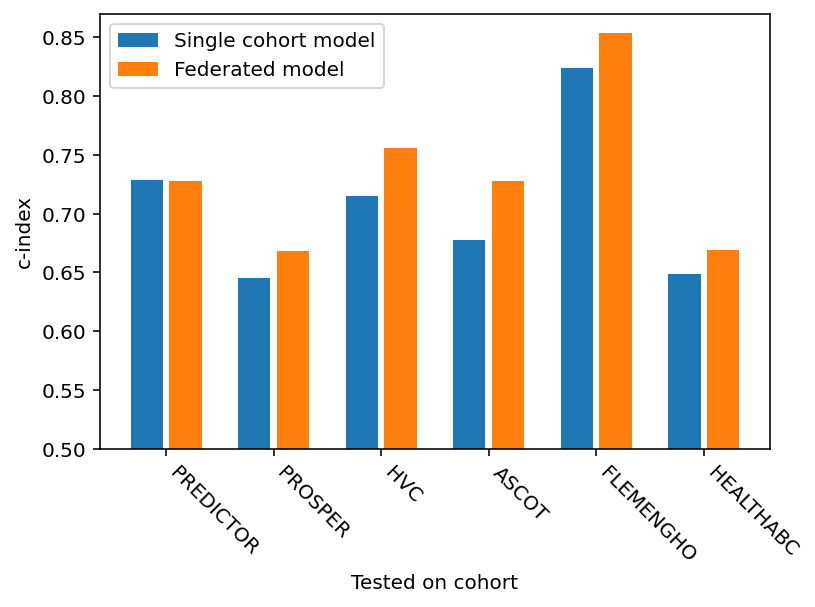

In [166]:
from hcve_lib.visualisation import savefig
import numpy as np
from matplotlib import pyplot
pyplot.figure(facecolor='white')
w = 0.3
x_ticks_labels = matrix_gb['Combined'].index
x_ticks = np.arange(len(x_ticks_labels))
pyplot.bar(x_ticks-w/2-0.03, matrix_gb['LM Mean'].values, w, label='Single cohort model')
pyplot.bar(x_ticks+w/2+0.03, matrix_gb['Combined'].values, w, label='Federated model')
pyplot.legend()
pyplot.ylim(0.5, 0.87)
pyplot.ylabel('c-index')
pyplot.xlabel('Tested on cohort')
pyplot.xticks(rotation=-45, ha='left', labels=x_ticks_labels, ticks=x_ticks)
savefig('./output/federated_single_comparison.svg')

In [ ]:
def get_subruns_of_latest(experiment_name: str, root_name: str):
    runs = get_completed_runs(experiment_name)
    root_runs = runs[is_root_run(runs)]
    run_method = root_runs.query(f'`tags.mlflow.runName` == "{root_name}"').iloc[0]
    return get_children_runs(runs, run_method['run_id'])


for method_name in ('coxnet',):
    run_splits = get_subruns_of_latest('optimized_lm', method_name)
    for _, run_split in run_splits.iterrows():
        b(run_split['tags.mlflow.runName'])
        result = load_pickled_artifact(run_split['run_id'], 'result')
        metrics = compute_standard_metrics(X, y, result)
        print(metrics)

